***Feature Selection***


> Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.


> We are going to perform a feature selection using the random forest algorithm.






In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Mounting G drive**


> You need to authenticate to GD in order to get the AWID dataset with the scripts.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Get the resources**

> Get all necessary resources from Google Drive, this works after the authentification.these resources are compressed to save some time.


In [2]:
!cp -rn "/content/drive/My Drive/AWID/AWID-CLS-R-Trn_with_headers.zip" .
!cp -rn "/content/drive/My Drive/AWID/AWID-CLS-R-Tst_with_headers.zip" .
!cp -rn "/content/drive/My Drive/Mahamdi's PFE/for Collab/utils.py" .
!cp -rn "/content/drive/My Drive/Mahamdi's PFE/for Collab/main.py" .
!cp -rn "/content/drive/My Drive/Mahamdi's PFE/for Collab/imports.py" .
!cp -rn "/content/drive/My Drive/Mahamdi's PFE/for Collab/class_report.py" .

!unzip AWID-CLS-R-Trn_with_headers.zip 
!unzip AWID-CLS-R-Tst_with_headers.zip 
!rm *.zip
!rm -rf sample_data/

Archive:  AWID-CLS-R-Trn_with_headers.zip
  inflating: AWID-CLS-R-Trn/AWID-CLS-R-Trn_with_headers.csv  
Archive:  AWID-CLS-R-Tst_with_headers.zip
  inflating: AWID-CLS-R-Tst/AWID-CLS-R-Tst_with_headers.csv  


***Imports***


> Import all necessary libraries.



In [0]:
from imports import *

***Read the data and replace the '?' string in the Pandas DataFrame with a NumPy NaN value***

In [0]:
train_path = '/content/AWID-CLS-R-Trn/AWID-CLS-R-Trn_with_headers.csv'
test_path = '/content/AWID-CLS-R-Tst/AWID-CLS-R-Tst_with_headers.csv'
train_df_raw = pd.read_csv(train_path, low_memory=False)
test_df_raw = pd.read_csv(test_path, low_memory=False)
train_df_raw.replace('?', np.nan, inplace=True)
test_df_raw.replace('?', np.nan, inplace=True)


**Drop these colomns**


> Each one of the dropped columns has a Nan rate of 1.
> Note that we need to drop them from both of training and validation sets.


In [0]:
del test_df_raw['frame.dlt']
del test_df_raw['wlan.qos.buf_state_indicated']
del test_df_raw['radiotap.mactime']
del test_df_raw['wlan.ba.bm']
del test_df_raw['wlan.ba.control.ackpolicy']
del test_df_raw['wlan.ba.control.cbitmap']
del test_df_raw['wlan.ba.control.multitid']
del test_df_raw['wlan.bar.compressed.tidinfo']
del test_df_raw['wlan.bar.type']
del test_df_raw['wlan_mgt.fixed.fragment']
del test_df_raw['wlan_mgt.fixed.sequence']
del test_df_raw['wlan_mgt.tcprep.link_mrg']
del test_df_raw['wlan_mgt.tcprep.trsmt_pow']


del train_df_raw['frame.dlt']
del train_df_raw['wlan.qos.buf_state_indicated']
del train_df_raw['radiotap.mactime']
del train_df_raw['wlan.ba.bm']
del train_df_raw['wlan.ba.control.ackpolicy']
del train_df_raw['wlan.ba.control.cbitmap']
del train_df_raw['wlan.ba.control.multitid']
del train_df_raw['wlan.bar.compressed.tidinfo']
del train_df_raw['wlan.bar.type']
del train_df_raw['wlan_mgt.fixed.fragment']
del train_df_raw['wlan_mgt.fixed.sequence']
del train_df_raw['wlan_mgt.tcprep.link_mrg']
del train_df_raw['wlan_mgt.tcprep.trsmt_pow']


***Data pre-processing***


> We need to treat the data before passing it to our model.



***Change any columns of strings in a panda's dataframe to a column of categorical values.***
 

> This applies the changes inplace.




In [0]:
str_to_cat(train_df_raw)

***Changes any columns of strings in df into categorical variables using trn as a template for the category codes***
 

> This applies the changes inplace too.




In [0]:
apply_cats(test_df_raw,train_df_raw)

***We're still not quite done !***
 
> For instance we have lots of missing values, which we can't pass directly to the model.




***We call  the function proc_df() to process a pandas dataframe !***
 

*   *proc_df*  takes a data frame df and splits off the response variable in our case the *class* colomn, and changes the df into an entirely numeric dataframe. For each column of df which is not in skip_flds nor in ignore_flds, na values are replaced by the median value of the column.
*    Three other funtions are called inside this function:
    *    ***numericalize()*** : Changes the column col from a categorical type to it's integer codes.
    *    ***fix_missing()*** : Fill missing data in a column of df with the median, and add a {name}_na column 
    which specifies if the data was missing.
    *    ***scale_vars()*** : Scale tha data.



In [0]:
x_train, y_train , nas , mapper = proc_df(train_df_raw, 'class', do_scale=True)
x_valid, y_valid , nas , _ = proc_df(test_df_raw,'class', na_dict=nas, do_scale=True, mapper=mapper)

***We are going to perform a classification with Rf then we pass to select the most important features***

Instantiate and train the model

In [9]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=200)
%time rf.fit(x_train, y_train) 

CPU times: user 8min 58s, sys: 1.35 s, total: 9min
Wall time: 2min 20s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

**Print the name and the importance of each feature**


> Note that every execution gives a different results.



In [11]:
feat_labels=train_df_raw.columns.values.tolist()
# Print the name and the importance of each feature
sorted(zip(map(lambda x: round(x, 3), rf.feature_importances_), feat_labels), reverse=True)

[(0.062, 'wlan.ta'),
 (0.049, 'wlan.da'),
 (0.048, 'wlan.wep.icv'),
 (0.046, 'wlan.fc.subtype'),
 (0.046, 'frame.cap_len'),
 (0.042, 'frame.time_delta_displayed'),
 (0.042, 'data.len'),
 (0.041, 'frame.len'),
 (0.04, 'frame.time_relative'),
 (0.039, 'wlan.ra'),
 (0.039, 'wlan.fc.ds'),
 (0.039, 'wlan.duration'),
 (0.039, 'frame.time_epoch'),
 (0.039, 'frame.time_delta'),
 (0.037, 'wlan.sa'),
 (0.031, 'wlan.wep.iv'),
 (0.03, 'wlan_mgt.fixed.reason_code'),
 (0.03, 'wlan.fc.pwrmgt'),
 (0.029, 'wlan.fc.type_subtype'),
 (0.027, 'radiotap.dbm_antsignal'),
 (0.024, 'wlan.seq'),
 (0.02, 'radiotap.datarate'),
 (0.014, 'wlan.fc.protected'),
 (0.013, 'wlan.fc.type'),
 (0.013, 'wlan.bssid'),
 (0.011, 'wlan.wep.key'),
 (0.009, 'wlan.fc.retry'),
 (0.008, 'radiotap.channel.type.ofdm'),
 (0.008, 'radiotap.channel.type.cck'),
 (0.007, 'wlan_mgt.fixed.timestamp'),
 (0.004, 'wlan_mgt.tagged.all'),
 (0.004, 'wlan_mgt.fixed.beacon'),
 (0.004, 'wlan_mgt.ds.current_channel'),
 (0.004, 'wlan.qos.ack'),
 (0.003

Let's create a selector object that will use the random forest classifier to identify features that have an importance of more than 0.03

In [12]:
sfm = SelectFromModel(rf, threshold=0.03)

# Train the selector
sfm.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=200, n_jobs=-1,
                                                 oob_score=False,
 

Print the names of the most important features

In [14]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

frame.time_epoch
frame.time_delta
frame.time_delta_displayed
frame.time_relative
frame.len
frame.cap_len
wlan.fc.subtype
wlan.fc.ds
wlan.fc.pwrmgt
wlan.duration
wlan.ra
wlan.da
wlan.ta
wlan.sa
wlan.wep.icv
data.len


We gonna use this set for the validation of our models

set :

      * frame.time_epoch
      * frame.time_delta
      * frame.time_delta_displayed
      * frame.time_relative
      * frame.len
      * frame.cap_len
      * wlan.fc.subtype
      * wlan.fc.ds
      * wlan.duration
      * wlan.ra
      * wlan.da
      * wlan.ta
      * wlan.sa
      * wlan.seq
      * wlan.wep.iv
      * wlan.wep.icv
      * data.len

Let's try now with a deterministic single tree

In [23]:
model = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time model.fit(x_train, y_train)

CPU times: user 1.6 s, sys: 534 ms, total: 2.14 s
Wall time: 2.14 s


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

*Draw the tree*

In [0]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',f'Tree {{ size={size}; ratio={ratio}', s)))

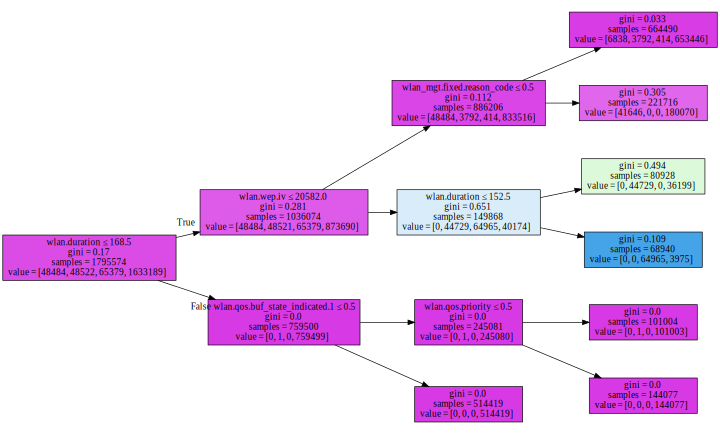

In [24]:
draw_tree(model.estimators_[0], x_train, precision=3)

**Save the work**

In [0]:
os.makedirs("FS", exist_ok=True)
dill.dump(sfm, open("FS/fs.obj", "wb"))
dill.dump(model, open("FS/fs2.obj", "wb"))


***Compress and save to Google Drive***

In [26]:
!zip -r FS.zip FS
!cp -f FS.zip "/content/drive/My Drive/Mahamdi's PFE/Models"

  adding: FS/ (stored 0%)
  adding: FS/fs2.obj (deflated 48%)
  adding: FS/fs.obj (deflated 80%)
